In [1]:
import dotenv
import pendulum
from gjk.config import Settings
from gjk.first_season.beech_channels import BEECH_CHANNELS_BY_NAME
from gjk.models import ReadingSql
from sqlalchemy import create_engine, asc
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
from gjk.enums import TelemetryName
from gjk.first_season.beech_channels import BEECH_CHANNELS_BY_NAME
import pendulum
from typing import Dict, List
from gjk.models import (
    DataChannelSql,
    ReadingSql,
)

settings = Settings(_env_file=dotenv.find_dotenv())
engine = create_engine(settings.db_url.get_secret_value())
Session = sessionmaker(bind=engine)
session = Session()

timezone = "America/New_York"
start = pendulum.datetime(2024, 2, 1, 0, 0, tz=timezone)
end = pendulum.datetime(2024, 2, 1, 1, 0, tz=timezone)

start_ms = int(start.timestamp() * 1000)
end_ms = int(end.timestamp() * 1000)

power_channels = [
    channel
    for channel in BEECH_CHANNELS_BY_NAME.values()
    if channel.telemetry_name == TelemetryName.GallonsTimes100.value
]

for channel in power_channels:
    print(channel.name)        
    print(channel.id)

oil-boiler-flow
251871dd-6dc8-40d9-a811-f62319461435
dist-flow-integrated
f28b814a-0579-4c9f-b08e-5e81e077dd1d
primary-flow-integrated
94c3ab5c-7dd1-43c5-9870-733930251396
store-flow-integrated
10fbb233-9987-4b5f-8b13-0f38fcff73b4


In [2]:
start = pendulum.datetime(2024, 2, 2, 0, 0, tz=timezone)
end = pendulum.datetime(2024, 2, 2, 23, 0, tz=timezone)

start_ms = int(start.timestamp() * 1000)
end_ms = int(end.timestamp() * 1000)

ewt = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == 'cecc9b94-9b4b-45ce-a8e9-4c63d24530aa').order_by(asc(ReadingSql.time_ms)).all()

lwt = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == 'a49db047-e38f-44a4-b773-29102c2fc526').order_by(asc(ReadingSql.time_ms)).all()

mhp = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == '94c3ab5c-7dd1-43c5-9870-733930251396').order_by(asc(ReadingSql.time_ms)).all()


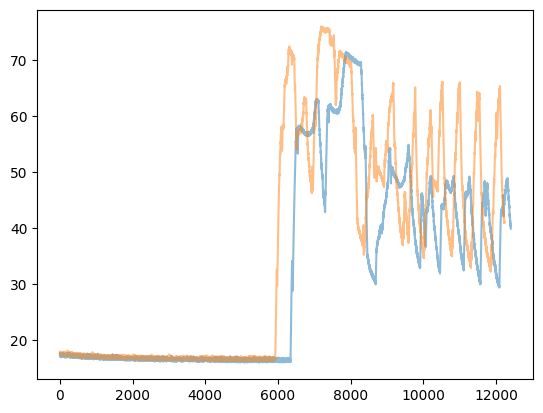

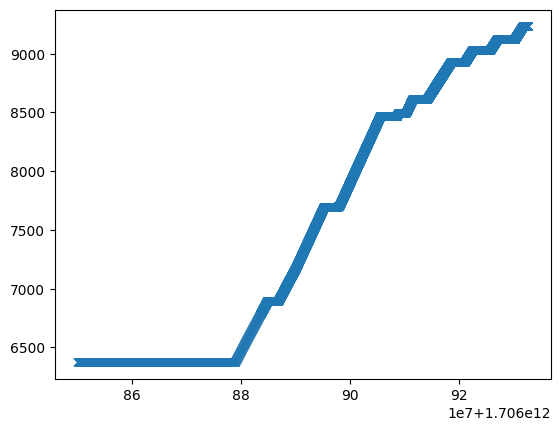

In [3]:
ewt_value_list = []
ewt_time_list = []
for e in ewt:
    if e.value > 0:
        ewt_value_list.append(e.value)
        ewt_time_list.append(e.time_ms)
ewt_time_list = [(x-ewt_time_list[0])/1000/60 for x in ewt_time_list]
ewt_value_list = [x/1000 for x in ewt_value_list]

lwt_value_list = []
lwt_time_list = []
for l in lwt:
    if l.value > 0:
        lwt_value_list.append(l.value)
        lwt_time_list.append(l.time_ms)
original_lwt_time_list = lwt_time_list
lwt_time_list = [(x-lwt_time_list[0])/1000/60 for x in lwt_time_list]
lwt_value_list = [x/1000 for x in lwt_value_list]

mhp_value_list = []
mhp_time_list = []
for m in mhp:
    mhp_value_list.append(m.value)
    mhp_time_list.append(m.time_ms)
mhp_value_list = [x/100 for x in mhp_value_list]

import matplotlib.pyplot as plt
plt.plot(ewt_value_list, alpha=0.5)
plt.plot(lwt_value_list, alpha=0.5)
plt.show()
plt.plot(mhp_time_list, mhp_value_list, '-x', alpha=0.1)
plt.show()

In [4]:
gallons = mhp_value_list.copy()
first = 1e9
gpms = [0]
times = [mhp_time_list[0]]

for i in range(len(gallons)):

    if gallons[i] > gallons[0]+0.5 and gallons[i]<first:
        timestamp1 = mhp_time_list[i]
        first = gallons[i]

    elif gallons[i] > first:
        timestamp2 = mhp_time_list[i]
        second = gallons[i]

        gpm = (second-first)/(timestamp2-timestamp1) * 1e3 * 60
        gpm_kgs = 3.78541*gpm/60
        gpms.append(gpm_kgs)
        times.append(timestamp1)

        first = 1e9
        gallons[0] = second

gpms.append(0)
times.append(mhp_time_list[-1])

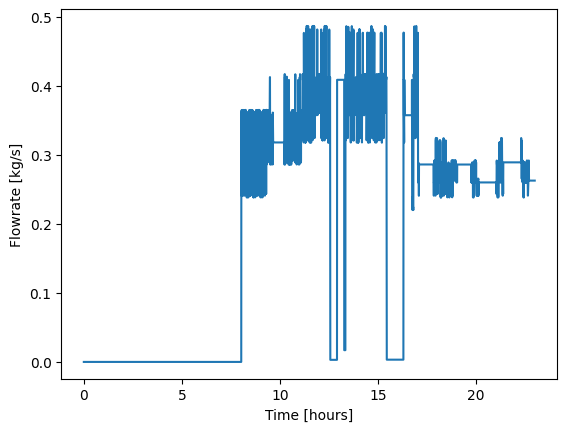

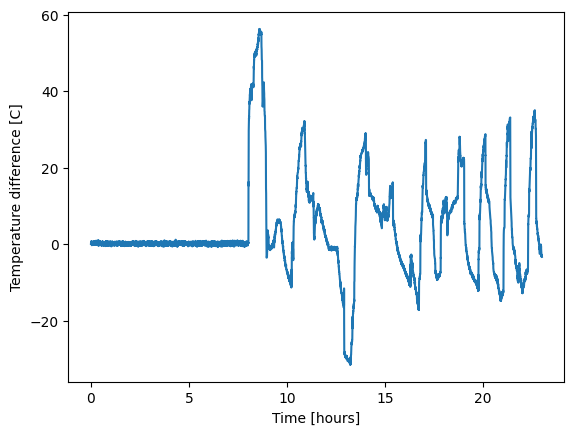

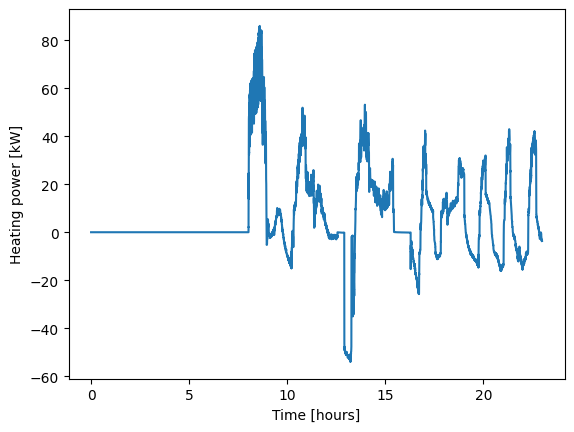

In [5]:
delta_t = [x-y for x,y in zip(lwt_value_list, ewt_value_list)]

import pandas as pd
df1 = pd.DataFrame({'time':times, 'GPM':gpms})
df2 = pd.DataFrame({'time':original_lwt_time_list, 'DELTA_T':delta_t})

merged = pd.merge_asof(df2.sort_values('time'), df1.sort_values('time'), on='time', direction='backward', suffixes=('', '_df1'))
merged['Q'] = (merged['GPM'] * 4187 * merged['DELTA_T'])/1000

merged['time'] = (merged['time']-list(merged.time)[0])/1000/60/60

plt.plot(merged.time, merged.GPM)
plt.xlabel('Time [hours]')
plt.ylabel('Flowrate [kg/s]')
plt.show()

plt.plot(merged.time, merged.DELTA_T)
plt.xlabel('Time [hours]')
plt.ylabel('Temperature difference [C]')
plt.show()

plt.plot(merged.time, merged.Q)
plt.xlabel('Time [hours]')
plt.ylabel('Heating power [kW]')
plt.show()
